In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train.zip" -d "/content/data"


In [ ]:
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
early_stopping_patience = config['training']['patience']
learning_rate = config['training'].get('learning_rate', 1e-4)
weight_decay = config['training'].get('weight_decay', 0.0)


root_dir = '/content/data/train'

In [ ]:
# Путь к данным
train_csv = config['dataset']['train_csv']
df = pd.read_csv(train_csv)

In [ ]:
df['true_label'] = df['true_label'].astype(int)
print("Распределение классов:")
print(df['true_label'].value_counts())

Распределение классов:
true_label
1    6260
2    6260
0    6260
Name: count, dtype: int64


In [ ]:
from torchvision import transforms
from PIL import Image
import os



def get_transform_pipeline(config, label=None):
    transform_list = []

    transform_config = config.get('train_transforms', {})
    common_transforms = transform_config.get('common', [])
    transform_list.extend(parse_transforms(common_transforms, config))

    # Классы 1 и 2 получают сильные аугментации
    if label in [1, 2]:
        label_key = str(label)
        class_specific = transform_config.get(label_key, [])
        transform_list.extend(parse_transforms(class_specific, config))

    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)

def parse_transforms(transform_names, config):
    transform_ops = []
    image_size = config['dataset']['image_size']
    transform_ops.append(transforms.Resize(image_size))

    for name in transform_names:
        if name == "horizontal_flip":
            transform_ops.append(transforms.RandomHorizontalFlip())
        elif name == "vertical_flip":
            transform_ops.append(transforms.RandomVerticalFlip())
        elif name == "color_jitter":
            transform_ops.append(transforms.ColorJitter(0.3, 0.3, 0.2, 0.1))
        elif name == "random_affine":
            transform_ops.append(transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5))
        elif name == "gaussian_blur":
            transform_ops.append(transforms.GaussianBlur(kernel_size=3))
        elif name == "random_erasing":
            transform_ops.append(transforms.RandomErasing(p=0.2))
        else:
            raise ValueError(f"Неизвестная трансформация: {name}")

    return transform_ops



In [ ]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        # Возвращаем изображение, метку и имя файла
        return image, label, img_name


In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, config, fold=0):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = config['training'].get('model_save_path', 'checkpoints/')
    num_epochs = config['training'].get('num_epochs', 20)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    scaler = GradScaler()  # грузим датасет

    if hasattr(model, 'vit'):
        for param in model.vit.parameters():
            param.requires_grad = False

    for epoch in range(num_epochs):
        if epoch == config['training'].get('freeze_encoder_epochs', 3):
            if hasattr(model, 'vit'):
                for param in model.vit.parameters():
                    param.requires_grad = True

        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # train
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds, all_probs, image_names = [], [], [], []

        with torch.no_grad():
            for inputs, labels, filenames in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():  # val
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)

                running_val_loss += loss.item()

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                image_names.extend(filenames)

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            save_path = os.path.join(model_save_path, f"baseline_vit_fold{fold + 1}.pth")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)  # <--- эта строка создаёт директорию, если нужно
            torch.save(model.state_dict(), save_path)

        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    num_classes = len(set(all_labels))
    print("\nFinal Metrics on Validation Set:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(all_labels, all_preds):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

    # AUC-ROC
    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")

    plot_training_history(train_losses, val_losses)
    return all_labels, all_preds, all_probs, image_names


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d92d42b19721>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-d92d42b19721>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # train
<ipython-input-11-d92d42b19721>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # val


Epoch 1/50 | Train Loss: 1.0995 | Val Loss: 1.0991
Epoch 2/50 | Train Loss: 1.0983 | Val Loss: 1.0980
Epoch 3/50 | Train Loss: 1.0971 | Val Loss: 1.0968
Epoch 4/50 | Train Loss: 1.0670 | Val Loss: 1.0354
Epoch 5/50 | Train Loss: 1.0000 | Val Loss: 0.9662
Epoch 6/50 | Train Loss: 0.9310 | Val Loss: 0.8985
Epoch 7/50 | Train Loss: 0.8668 | Val Loss: 0.8406
Epoch 8/50 | Train Loss: 0.8163 | Val Loss: 0.7978
Epoch 9/50 | Train Loss: 0.7790 | Val Loss: 0.7664
Epoch 10/50 | Train Loss: 0.7518 | Val Loss: 0.7434
Epoch 11/50 | Train Loss: 0.7319 | Val Loss: 0.7270
Epoch 12/50 | Train Loss: 0.7161 | Val Loss: 0.7145
Epoch 13/50 | Train Loss: 0.7044 | Val Loss: 0.7062
Epoch 14/50 | Train Loss: 0.6948 | Val Loss: 0.6968
Epoch 15/50 | Train Loss: 0.6871 | Val Loss: 0.6912
Epoch 16/50 | Train Loss: 0.6801 | Val Loss: 0.6853
Epoch 17/50 | Train Loss: 0.6742 | Val Loss: 0.6812
Epoch 18/50 | Train Loss: 0.6690 | Val Loss: 0.6776
Epoch 19/50 | Train Loss: 0.6645 | Val Loss: 0.6740
Epoch 20/50 | Train L

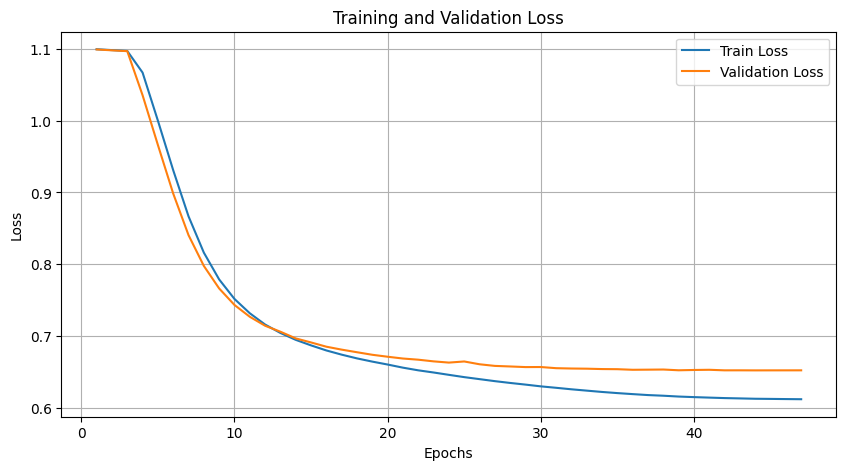


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d92d42b19721>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-d92d42b19721>:3

Epoch 1/50 | Train Loss: 1.1153 | Val Loss: 1.1144
Epoch 2/50 | Train Loss: 1.1140 | Val Loss: 1.1131
Epoch 3/50 | Train Loss: 1.1128 | Val Loss: 1.1119
Epoch 4/50 | Train Loss: 1.0829 | Val Loss: 1.0534
Epoch 5/50 | Train Loss: 1.0179 | Val Loss: 0.9792
Epoch 6/50 | Train Loss: 0.9382 | Val Loss: 0.8980
Epoch 7/50 | Train Loss: 0.8611 | Val Loss: 0.8281
Epoch 8/50 | Train Loss: 0.8005 | Val Loss: 0.7772
Epoch 9/50 | Train Loss: 0.7575 | Val Loss: 0.7431
Epoch 10/50 | Train Loss: 0.7288 | Val Loss: 0.7213
Epoch 11/50 | Train Loss: 0.7093 | Val Loss: 0.7063
Epoch 12/50 | Train Loss: 0.6958 | Val Loss: 0.6953
Epoch 13/50 | Train Loss: 0.6856 | Val Loss: 0.6878
Epoch 14/50 | Train Loss: 0.6779 | Val Loss: 0.6822
Epoch 15/50 | Train Loss: 0.6714 | Val Loss: 0.6777
Epoch 16/50 | Train Loss: 0.6664 | Val Loss: 0.6742
Epoch 17/50 | Train Loss: 0.6620 | Val Loss: 0.6710
Epoch 18/50 | Train Loss: 0.6581 | Val Loss: 0.6687
Epoch 19/50 | Train Loss: 0.6545 | Val Loss: 0.6665
Epoch 20/50 | Train L

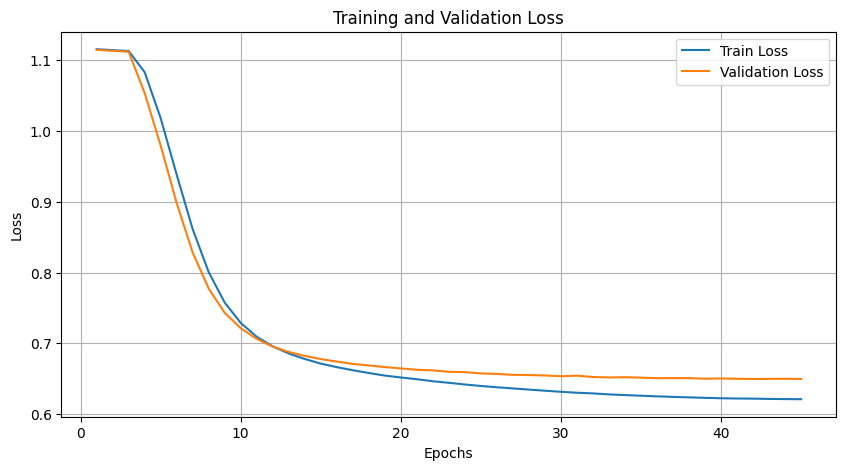


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d92d42b19721>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # грузим датасет
<ipython-input-11-d92d42b19721>:3

Epoch 1/50 | Train Loss: 1.1074 | Val Loss: 1.1055
Epoch 2/50 | Train Loss: 1.1064 | Val Loss: 1.1045
Epoch 3/50 | Train Loss: 1.1054 | Val Loss: 1.1035
Epoch 4/50 | Train Loss: 1.0783 | Val Loss: 1.0458
Epoch 5/50 | Train Loss: 1.0076 | Val Loss: 0.9684
Epoch 6/50 | Train Loss: 0.9302 | Val Loss: 0.8962
Epoch 7/50 | Train Loss: 0.8624 | Val Loss: 0.8372
Epoch 8/50 | Train Loss: 0.8098 | Val Loss: 0.7928
Epoch 9/50 | Train Loss: 0.7708 | Val Loss: 0.7614
Epoch 10/50 | Train Loss: 0.7427 | Val Loss: 0.7387
Epoch 11/50 | Train Loss: 0.7219 | Val Loss: 0.7229
Epoch 12/50 | Train Loss: 0.7075 | Val Loss: 0.7114
Epoch 13/50 | Train Loss: 0.6963 | Val Loss: 0.7026
Epoch 14/50 | Train Loss: 0.6871 | Val Loss: 0.6959
Epoch 15/50 | Train Loss: 0.6793 | Val Loss: 0.6905
Epoch 16/50 | Train Loss: 0.6730 | Val Loss: 0.6863
Epoch 17/50 | Train Loss: 0.6676 | Val Loss: 0.6823
Epoch 18/50 | Train Loss: 0.6627 | Val Loss: 0.6794
Epoch 19/50 | Train Loss: 0.6589 | Val Loss: 0.6768
Epoch 20/50 | Train L

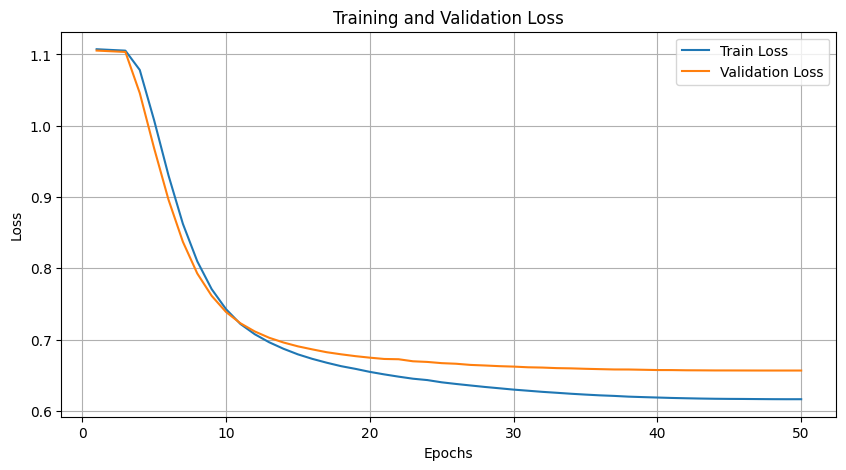


 Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'


In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import os

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # --- Создание датасетов и загрузчиков ---
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=22, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=22, pin_memory=True)

    # --- Создание модели ---
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.to(device)

    # --- Оптимизатор и шедулер ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler_type = config['training'].get('scheduler', 'cosine').lower()
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_type}")

    # --- Обновляем путь для сохранения модели ---
    config['training']['model_save_path'] = f"best_model_fold{fold + 1}.pth"

    # --- Обучение модели на фолде ---
    labels, preds, probs, image_names = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, config, fold=fold
    )

    # --- Сохраняем предсказания фолда ---
    fold_df = pd.DataFrame({
        'image_name': image_names,
        'true_label': labels,
        'pred_label': preds,
        'fold': fold + 1
    })
    all_results.append(fold_df)

# --- Объединяем и сохраняем ---
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("kfold_vit_predictions.csv", index=False)
print("\n Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'")
